The idea is to implement here an architecture similar to the one developed in "Datadriven wind turbine wake modeling via probabilistic Machine Learning":
- autoencoder trained on the output wake field
- MLP from input to latent space which is then plugged to the trained decoder to obtain the actual desired output

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
from math import floor, ceil

from utils.metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
import utils.utils as uutils
import utils.data_utils as data_utils
import utils.plotting as plotting
from utils.evaluation import test_pytorch_model

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
LATENT_SPACE = 8
CONVOLUTIONAL = True

BATCH_SIZE = 64
EPOCHS = 500
LR = 1e-3
CONSIDER_WS = False
COORDS_AS_INPUT = False # multivariate data
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

In [44]:
# autoencoders hyperparameters
if not CONVOLUTIONAL:
    HIDDEN_LAYERS_UNITS = [LATENT_SPACE, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
    ACTIVATION_FUNCTION = nn.Sigmoid()
    MODEL_NAME = f"autoencoders_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}_{train_reduc_factor_string}"

class AutoEncoder(nn.Module):
    def __init__(self, layer_dimensions: list[int], num_cells: int, activation_function, flatten: bool = False):
        super(AutoEncoder, self).__init__()
        self.act_function = activation_function
        incr = sorted(layer_dimensions)
        decr = sorted(layer_dimensions, reverse=True)
        
        encoder_layers = self.__generate_encoder_layers(num_cells, decr)
        decoder_layers = self.__generate_decoder_layers(num_cells, incr)
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
    
    def __generate_encoder_layers(self, num_cells: int, decr_layers_units: list[int]):
        encoder_layers = []
        encoder_layers += [nn.Linear(num_cells, decr_layers_units[0]), self.act_function]
        for first, second in zip(decr_layers_units, decr_layers_units[1:]):
            encoder_layers += [nn.Linear(first, second), self.act_function] #TODO activate last layer?
        return encoder_layers

    def __generate_decoder_layers(self, num_cells: int, incr_layers_units: list[int]):
        decoder_layers = []
        for first, second in zip(incr_layers_units, incr_layers_units[1:]):
            decoder_layers += [nn.Linear(first, second), self.act_function]
        decoder_layers += [nn.Linear(incr_layers_units[-1], num_cells), self.act_function] #TODO activate last layer?
        return decoder_layers
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [45]:
#Link for Convolutional Autoencoder https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

# convolutional autoencoders hyperparameters
# TODO change parameters of convolutional layers according also to the final grid shape
if CONVOLUTIONAL:
    HIDDEN_LINEAR_LAYERS_UNITS = sorted([LATENT_SPACE, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])[::-1]
    CHANNELS = [2, 4, 8, 8]
    KERNEL_SIZES = [3, 4, 5, 5]
    STRIDES = [2] * len(CHANNELS)
    PADDINGS = [1] * len(CHANNELS)
    assert len(CHANNELS) == len(KERNEL_SIZES) == len(STRIDES) == len(PADDINGS)
    CONV_INPUTS = [(c_in, c_out, ks, s, p) for c_in, c_out, ks, s, p in \
                zip([1] + CHANNELS[:-1], CHANNELS, KERNEL_SIZES, STRIDES, PADDINGS)] # first has one channel (wind deficit)
    ACTIVATION_FUNCTION = nn.ReLU()
    CONVOLUTIONAL = True

    MODEL_NAME = f"conv_autoencoders_channels{'-'.join(str(c) for c in CHANNELS)}_"\
        f"kernels{'-'.join(str(k) for k in KERNEL_SIZES)}_"\
        f"strides{'-'.join(str(s) for s in STRIDES)}_"\
        f"paddings{'-'.join(str(p) for p in PADDINGS)}_"\
        f"lin-layers{'-'.join(str(lu) for lu in HIDDEN_LINEAR_LAYERS_UNITS)}_"\
        f"{train_reduc_factor_string}"


class ReshapeInputModule(nn.Module):
    """Dividing the two dimensions of the wake field and adding a dimension for the channel"""
    def __init__(self, field_shape):
        super(ReshapeInputModule, self).__init__()
        self.field_shape = field_shape
    
    def forward(self, x):
        x = x.view(-1, *self.field_shape)
        x = torch.unsqueeze(x, 1)
        return x

class RestoreShapeModule(nn.Module):
    """Restoring the original 1-dimensional shape of the wake field"""
    def __init__(self):
        super(RestoreShapeModule, self).__init__()
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        return x

#TODO delete
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        #print(x.shape)
        return x

#TODO move somewhere else
#TODO change name (it's not about output and input, it's about Conv or ConvTranspose)
#TODO this function is not really working in case of big kernel sizes or decreasing channels (?)
def conv_output_shape(input_shape, output_channels, kernel_size=1, stride=1, padding=0, dilation=1):
    assert len(input_shape) == 3 # no batch_size
    in_channels, h_in, w_in  = input_shape
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h_out = floor( ((h_in + (2 * padding) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w_out = floor( ((w_in + (2 * padding) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)

    return [output_channels, h_out, w_out]

#TODO move somewhere else (only if you will use it)
#TODO change name (it's not about output and input, it's about Conv or ConvTranspose)
def conv_transpose_output_shape(input_shape, output_channels, kernel_size=1, stride=1, padding=0, output_padding=0, dilation=1):
    assert len(input_shape) == 3  # no batch_size
    in_channels, h_in, w_in = input_shape
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    
    # Compute the input shape
    h_out = ceil((h_in - 1) * stride - 2 * padding + dilation * (kernel_size[0] - 1) + output_padding + 1)
    w_out = ceil((w_in - 1) * stride - 2 * padding + dilation * (kernel_size[1] - 1) + output_padding + 1)

    return [output_channels, h_out, w_out]

#TODO fix the following two functions as well
def get_dim_out_conv_transpose(dim_in, kernel_size, padding, stride, dilation, output_padding):
    return ceil((dim_in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1)

def compute_output_padding(input_shape, output_shape, kernel_size=1, stride=1, padding=0, dilation=1):
    #TODO find smarter solution to find this value
    assert len(input_shape) == 2  # no batch_size nor channel
    assert len(output_shape) == 2 # no batch_size nor channel
    h_in, w_in = input_shape
    h_out, w_out = output_shape
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    
    output_padding1 = 0
    while True:
        h_gen = get_dim_out_conv_transpose(h_in, kernel_size[0], padding, stride, dilation, output_padding1)
        if h_gen == h_out:
            break
        output_padding1 += 1
    
    output_padding2 = 0
    while True:
        w_gen = get_dim_out_conv_transpose(w_in, kernel_size[1], padding, stride, dilation, output_padding2)
        if w_gen == w_out:
            break
        output_padding2 += 1
    
    return output_padding1, output_padding2

def product(list: list[int]) -> int:
    product = 1
    for el in list:
        product *= el
    return product

class ConvEncoder(nn.Module):

    def __init__(self, field_shape):
        super().__init__()
        
        ### Convolutional section
        conv_shapes = [ [1] + list(field_shape) ]
        cnn_layers = [PrintLayer(), ReshapeInputModule(field_shape), PrintLayer()]
        for in_channels, out_channels, kernel_size, stride, padding in CONV_INPUTS:
            # shape after Conv2d: [batch_size, C_in, H_old, W_old] = [batch_size, C_out, H_new, W_new]
            cnn_layers += [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                           PrintLayer(),
                           nn.BatchNorm2d(out_channels), #TODO mettere o no????
                           ACTIVATION_FUNCTION]
            conv_shapes += [conv_output_shape(conv_shapes[-1], out_channels, kernel_size, stride, padding)]
        self.encoder_cnn = nn.Sequential(*cnn_layers)
        self.conv_shapes = conv_shapes

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        linear_units = [product(conv_shapes[-1])] + HIDDEN_LINEAR_LAYERS_UNITS
        linear_layers = [PrintLayer()]
        for first, second in zip(linear_units, linear_units[1:]):
            linear_layers += [nn.Linear(first, second), ACTIVATION_FUNCTION, PrintLayer()]
        # last layer is activated as well
        self.encoder_lin = nn.Sequential(*linear_layers)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class ConvDecoder(nn.Module):
    
    def __init__(self, transp_conv_shapes: list[list[int]]):
        super().__init__()
        ### Linear section
        linear_units = HIDDEN_LINEAR_LAYERS_UNITS[::-1] + [product(transp_conv_shapes[0])]
        linear_layers = list()
        for first, second in zip(linear_units, linear_units[1:]):
            linear_layers += [nn.Linear(first, second), ACTIVATION_FUNCTION, PrintLayer()]
        self.decoder_lin = nn.Sequential(*linear_layers)

        ### Flatten layer
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=transp_conv_shapes[0])

        ### Convolutional section
        cnn_layers = [PrintLayer()]
        for i, (in_channels, out_channels, kernel_size, stride, padding) in enumerate(CONV_INPUTS[::-1]):
            output_padding = compute_output_padding(transp_conv_shapes[i][-2:], transp_conv_shapes[i+1][-2:],
                                                    kernel_size, stride, padding)
            cnn_layers += [nn.ConvTranspose2d(out_channels, in_channels, kernel_size, stride, padding,
                                             output_padding=output_padding),
                           PrintLayer(),
                           nn.BatchNorm2d(in_channels), #TODO mettere o no????
                           ACTIVATION_FUNCTION]
        cnn_layers += [RestoreShapeModule(), PrintLayer()]
        self.decoder_cnn = nn.Sequential(*cnn_layers)
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_cnn(x)
        x = torch.sigmoid(x) #TODO??????
        return x

class ConvAutoEncoder(nn.Module):
    def __init__(self, field_shape) -> None:
        super().__init__() 
        self.encoder = ConvEncoder(field_shape)
        self.decoder = ConvDecoder(self.encoder.conv_shapes[::-1])
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [17]:
"CODE TO TEST THE CONVOLUTION AUTOENCODER STRUCTURE" #TODO move or delete

shape1 = [1, 32, 224]
shape2 = [2, 15, 111]
shape3 = [4, 7, 55]
shape4 = [8, 3, 27]
shape5 = [16, 1, 13]

kernel_size = 3
stride = 2
padding = 1

print(shape1)
print(conv_output_shape(shape2, 2, 5, 2, 1))
print(conv_output_shape(shape2, 4, 5, 2, 1))
print(conv_output_shape(shape3, 8, 5, 2, 1))
print(conv_output_shape(shape4, 16, 5, 2, 1))
print("---")
print(shape5)
output_padding = compute_output_padding(shape5[-2:], shape4[-2:], kernel_size=kernel_size, stride=stride, padding=padding)[0]
print(conv_transpose_output_shape(shape5, output_channels=8, kernel_size=kernel_size, stride=stride, padding=padding,
                                  output_padding=output_padding))

output_padding = compute_output_padding(shape4[-2:], shape3[-2:], kernel_size=kernel_size, stride=stride, padding=padding)[0]
print(conv_transpose_output_shape(shape4, output_channels=4, kernel_size=kernel_size, stride=stride, padding=padding,
                                  output_padding=output_padding))
output_padding = compute_output_padding(shape3[-2:], shape2[-2:], kernel_size=kernel_size, stride=stride, padding=padding)[0]
print(conv_transpose_output_shape(shape3, output_channels=2, kernel_size=kernel_size, stride=stride, padding=padding,
                                  output_padding=output_padding))
output_padding = compute_output_padding(shape2[-2:], shape1[-2:], kernel_size=kernel_size, stride=stride, padding=padding)[0]
print(conv_transpose_output_shape(shape2, output_channels=1, kernel_size=kernel_size, stride=stride, padding=padding,
                                  output_padding=output_padding))

[1, 32, 224]
[2, 7, 55]
[4, 7, 55]
[8, 3, 27]
[16, 1, 13]
---
[16, 1, 13]
[8, 3, 27]
[4, 7, 55]
[2, 15, 111]
[1, 32, 224]


### Data loading

In [7]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          #train_perc=0.6,
                                                          #test_perc=0.2,
                                                          #validation_perc=0.2,
                                                          input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader), len(test_dataloader)

(129, 35)

In [18]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([64, 3]) torch.Size([64, 7168])
input_space=3	output_space=7168


### Autoencoder definition

In [47]:
if CONVOLUTIONAL:
    autoencoder = ConvAutoEncoder(train_dataloader.dataset.X_grid.shape).to(DEVICE)
else:
    autoencoder = AutoEncoder(HIDDEN_LAYERS_UNITS, train_dataloader.dataset.num_cells, ACTIVATION_FUNCTION).to(DEVICE)
print(autoencoder)

BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f", batch size {BATCH_SIZE}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")

ConvAutoEncoder(
  (encoder): ConvEncoder(
    (encoder_cnn): Sequential(
      (0): PrintLayer()
      (1): ReshapeInputModule()
      (2): PrintLayer()
      (3): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): PrintLayer()
      (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (8): PrintLayer()
      (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Conv2d(4, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (12): PrintLayer()
      (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): ReLU()
      (15): Conv2d(8, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (16): PrintLayer()
      (17): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (18): ReLU()
    )
   

### Autoencoder training

In [48]:
optimizer = torch.optim.Adam(
    [p for p in autoencoder.parameters() if p.requires_grad], lr=LR
)
loss_function = nn.MSELoss(reduction='mean')

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    autoencoder.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        wake_field = batch[1].to(DEVICE) # only considering the wake field (not the input variables)
        optimizer.zero_grad()
        reconstructed_wake_field = autoencoder(wake_field)
        tloss = loss_function(reconstructed_wake_field, wake_field)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item() * BATCH_SIZE

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        autoencoder.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            wake_field = batch[1].to(DEVICE) # only considering the wake field (not the input variables)
            reconstructed_wake_field = autoencoder(wake_field)
            vloss = loss_function(reconstructed_wake_field, wake_field)

            epoch_vloss += vloss.item() * BATCH_SIZE

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(autoencoder.state_dict(), BEST_MODEL_PATH)

Logging conv_autoencoders_channels2-4-8-8_kernels3-4-5-5_strides2-2-2-2_paddings1-1-1-1_lin-layers4096-2048-1024-512-256-128-64-32-16-8_consider_ws
Epoch 0 ->	Training loss=0.24163145851366447	Validation loss=0.2378367770801891	epoch_time (seconds)=39	
Epoch 1 ->	Training loss=0.23304685546412612	Validation loss=0.2366670794920488	epoch_time (seconds)=40	
Epoch 2 ->	Training loss=0.23266106842503403	Validation loss=0.2366666299646551	epoch_time (seconds)=37	
Epoch 3 ->	Training loss=0.2326606866085168	Validation loss=0.23666592728007924	epoch_time (seconds)=38	
Epoch 4 ->	Training loss=0.23265938221324575	Validation loss=0.23665321653539484	epoch_time (seconds)=37	
Epoch 5 ->	Training loss=0.23232977745749733	Validation loss=0.23615049448880282	epoch_time (seconds)=36	
Epoch 6 ->	Training loss=0.23215142984101267	Validation loss=0.23615049448880282	epoch_time (seconds)=43	
Epoch 7 ->	Training loss=0.23215386523622455	Validation loss=0.23615049448880282	epoch_time (seconds)=40	
Epoch 8 

KeyboardInterrupt: 

epoch_time (seconds)=277	

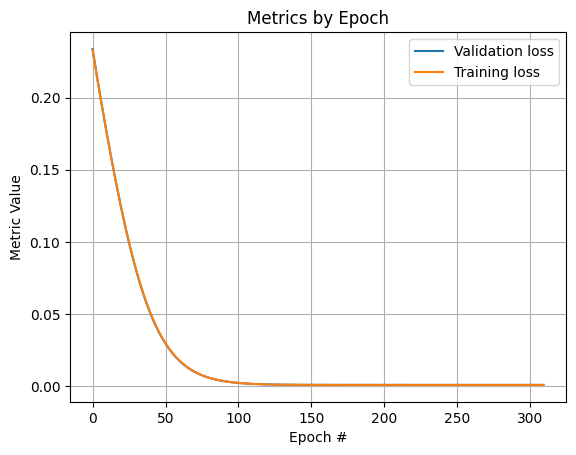

Metrics exported in the following csv file: logged_metrics/autoencoders_layers8-16-32-64-128-256-512-1024-2048-4096_consider_ws_consider_ws_17-06-2023_22-53-45.csv


In [ ]:
metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Second part: MLP from input to latent space which is then plugged to the decoder

For the training of this second part, there are two main options:
- to calculate the loss as the final difference between the reconstructed output and the ground truth output -> it may be unfair because it would evaluate also the capacity of the decoder to reconstruct the field from the latent space
- to calculate the loss on the latent space (output of this model and the output of the previously-trained encoder) -> it may be uncorrect because it would learn from the ground truth but from a latent space that is obtained from the trained encoder

In [ ]:
# loading best autoencoder
if CONVOLUTIONAL:
    autoencoder = ConvAutoEncoder(train_dataloader.dataset.X_grid.shape).to(DEVICE)
else:
    autoencoder = AutoEncoder(HIDDEN_LAYERS_UNITS, train_dataloader.dataset.num_cells, ACTIVATION_FUNCTION).to(DEVICE)
autoencoder.load_state_dict(torch.load(BEST_MODEL_PATH))
autoencoder.eval()

bottleneck_space = min(HIDDEN_LAYERS_UNITS) # minimum of autoencoder hidden units
print(f"{bottleneck_space=}")
final_model_description = "Autoencoder description: " + MODEL_DESCRIPTION
autoencoder

bottleneck_space=8


AutoEncoder(
  (act_function): Sigmoid()
  (encoder): Sequential(
    (0): Linear(in_features=7168, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): Sigmoid()
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): Sigmoid()
    (14): Linear(in_features=64, out_features=32, bias=True)
    (15): Sigmoid()
    (16): Linear(in_features=32, out_features=16, bias=True)
    (17): Sigmoid()
    (18): Linear(in_features=16, out_features=8, bias=True)
    (19): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Sigmoid()
    (2):

In [ ]:
# new hyperparameters
HIDDEN_LAYERS_UNITS = [6, 24, 48, 16]
ACTIVATION_FUNCTION = nn.ReLU()
EPOCHS = 500
LR = 0.001

MODEL_NAME = f"aemlp_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f"(not last layer), batch size {BATCH_SIZE}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")
final_model_description += " --- MLP description: " + MODEL_DESCRIPTION

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE=}")

Model name: aemlp_layers6-24-48-16_consider_ws
Best model path: saved_models/discr_factors_x2_30_y-2_2_step0.125_reducedTI-CT/aemlp_layers6-24-48-16_consider_ws.pt
Model description: aemlp_layers6-24-48-16_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)
DEVICE=device(type='cpu')


In [ ]:
class AE_MLP(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(AE_MLP, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = AE_MLP(input_space, bottleneck_space)

optimizer = torch.optim.Adam(
    (p for p in mlp.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss() #TODO change ?

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    mlp.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()

        bottleneck_pred = mlp.forward(input_features)
        bottleneck_truth = autoencoder.encoder(wake_field)
        
        tloss = loss_function(bottleneck_pred, bottleneck_truth)
        tloss.backward()
        optimizer.step()

        epoch_tloss += tloss.item() * BATCH_SIZE

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        mlp.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)

            bottleneck_pred = mlp.forward(input_features)
            bottleneck_truth = autoencoder.encoder(wake_field)

            vloss = loss_function(bottleneck_pred, bottleneck_truth)
            epoch_vloss += vloss.item() * BATCH_SIZE

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(mlp.state_dict(), BEST_MODEL_PATH)

Logging aemlp_layers6-24-48-16_consider_ws
Epoch 0 ->	Training loss=0.07314136055766633	Validation loss=0.0003412251500412822	epoch_time (seconds)=13	
Epoch 1 ->	Training loss=0.00014672468235772668	Validation loss=6.486045948060398e-05	epoch_time (seconds)=12	
Epoch 2 ->	Training loss=2.861561095624259e-05	Validation loss=2.061709043284116e-05	epoch_time (seconds)=12	
Epoch 3 ->	Training loss=1.3483074267931057e-05	Validation loss=1.4237502552780577e-05	epoch_time (seconds)=13	
Epoch 4 ->	Training loss=9.788317969209995e-06	Validation loss=1.1020488038246351e-05	epoch_time (seconds)=13	
Epoch 5 ->	Training loss=7.474069190776032e-06	Validation loss=8.627186206550422e-06	epoch_time (seconds)=13	
Epoch 6 ->	Training loss=5.877744854484318e-06	Validation loss=7.385496964244257e-06	epoch_time (seconds)=13	
Epoch 7 ->	Training loss=4.7285619339990345e-06	Validation loss=5.98602987751788e-06	epoch_time (seconds)=13	
Epoch 8 ->	Training loss=3.89605063758085e-06	Validation loss=5.13090814572

KeyboardInterrupt: 

epoch_time (seconds)=10	

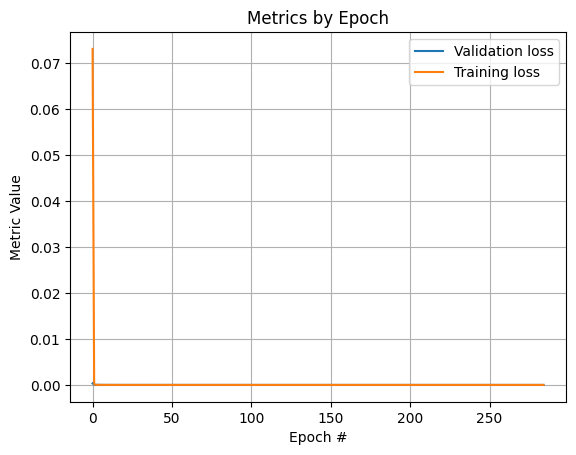

Metrics exported in the following csv file: logged_metrics/aemlp_layers6-24-48-16_consider_ws_18-06-2023_11-30-11.csv


In [ ]:
metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Testing

In [ ]:
# loading best mlp
mlp = AE_MLP(input_space, bottleneck_space).to(DEVICE)
mlp.load_state_dict(torch.load(BEST_MODEL_PATH))
mlp.eval()

mlp

AE_MLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=48, bias=True)
    (5): ReLU()
    (6): Linear(in_features=48, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [ ]:
class FinalModel(nn.Module): #TODO change name
    def __init__(self, mlp: AE_MLP, autoencoder: AutoEncoder):
        super(FinalModel, self).__init__()
        self.mlp = mlp
        self.autoencoder = autoencoder

    def forward(self, x):
        x = self.mlp(x)
        x = self.autoencoder.decoder(x)
        return x


In [ ]:
# loading best model
model = FinalModel(mlp, autoencoder).to(DEVICE)
model.eval()

test_pytorch_model(model, test_dataloader,
                   model_description=final_model_description,
                   save_results=True)

Test results for Autoencoder description: autoencoders_layers8-16-32-64-128-256-512-1024-2048-4096_consider_ws_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. Sigmoid , batch size 64, 500 epochs, lr=1e-07) --- MLP description: aemlp_layers15-50_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001) --- MLP description: aemlp_layers6-24-48-16_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)
r2_score=-0.042292121328531815
explained_variance_score=-8.386892399617604e-08
mean_squared_error=0.0007387474761344492
mean_absolute_error=0.012437290512025356
median_absolute_error=0.010045387782156467
mean_absolute_percentage_error=2127821930496.0
Prediction time=0.0007970060001720082s


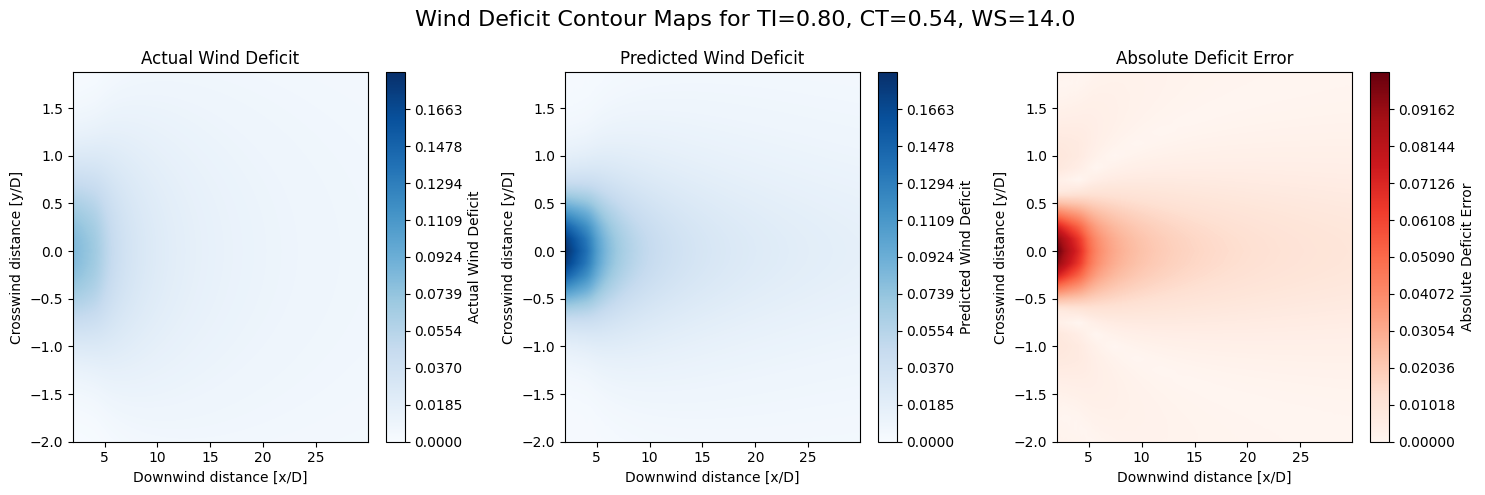

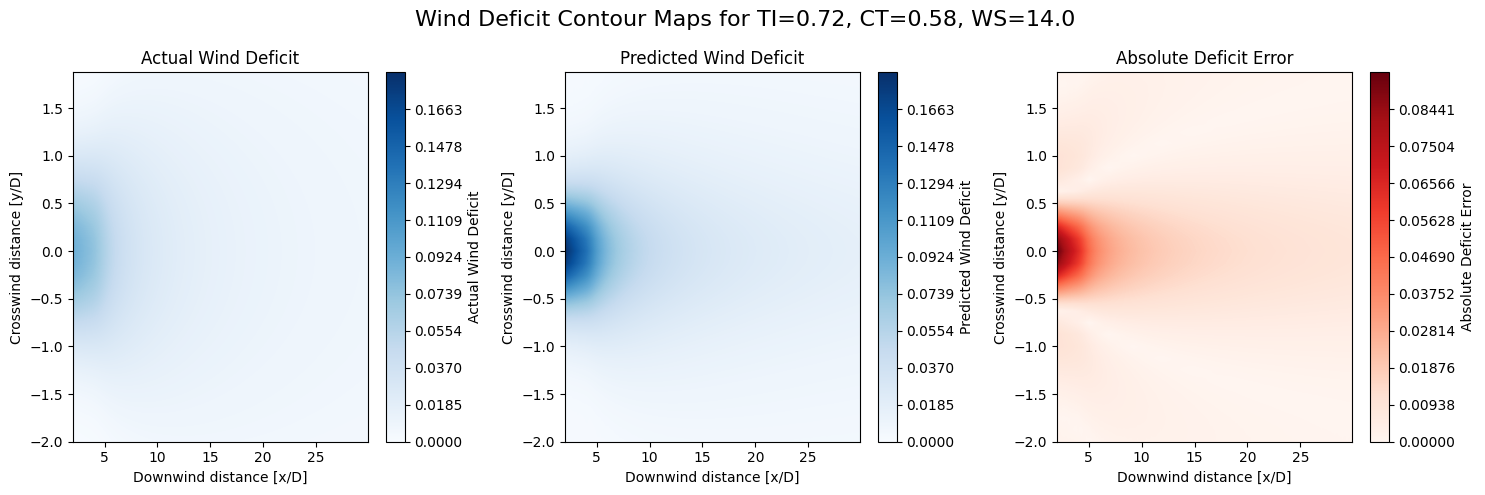

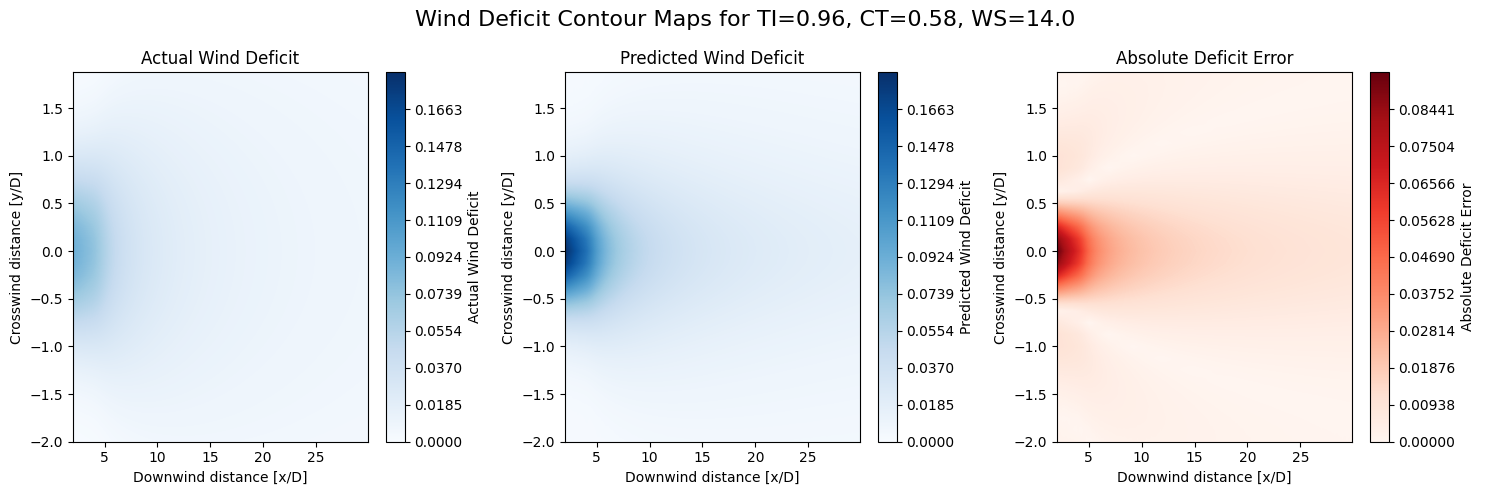

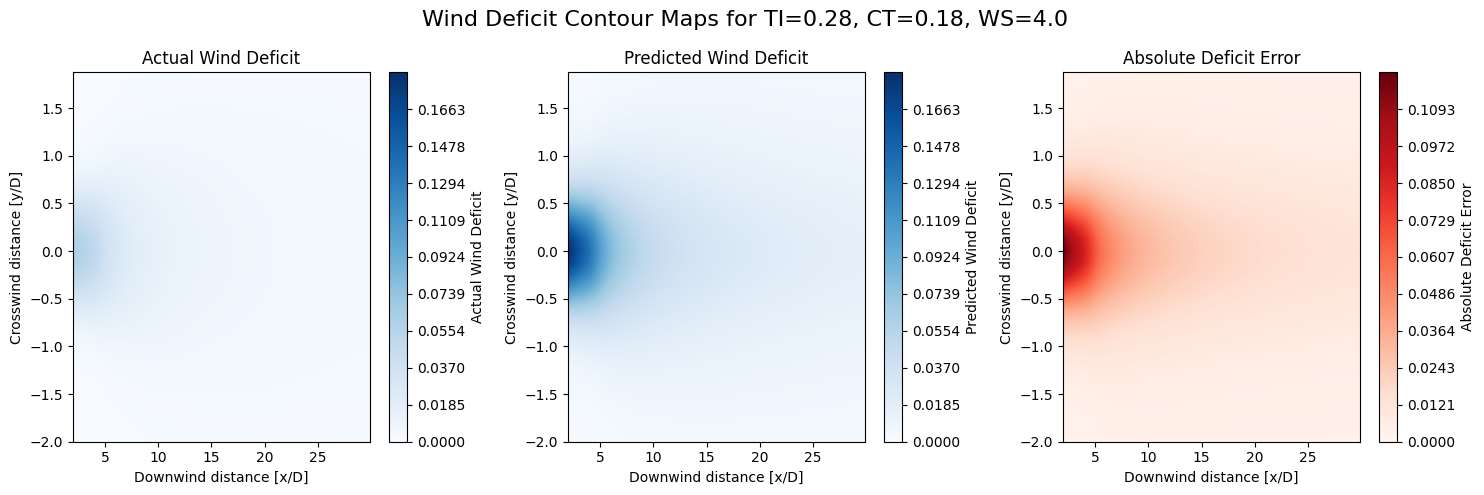

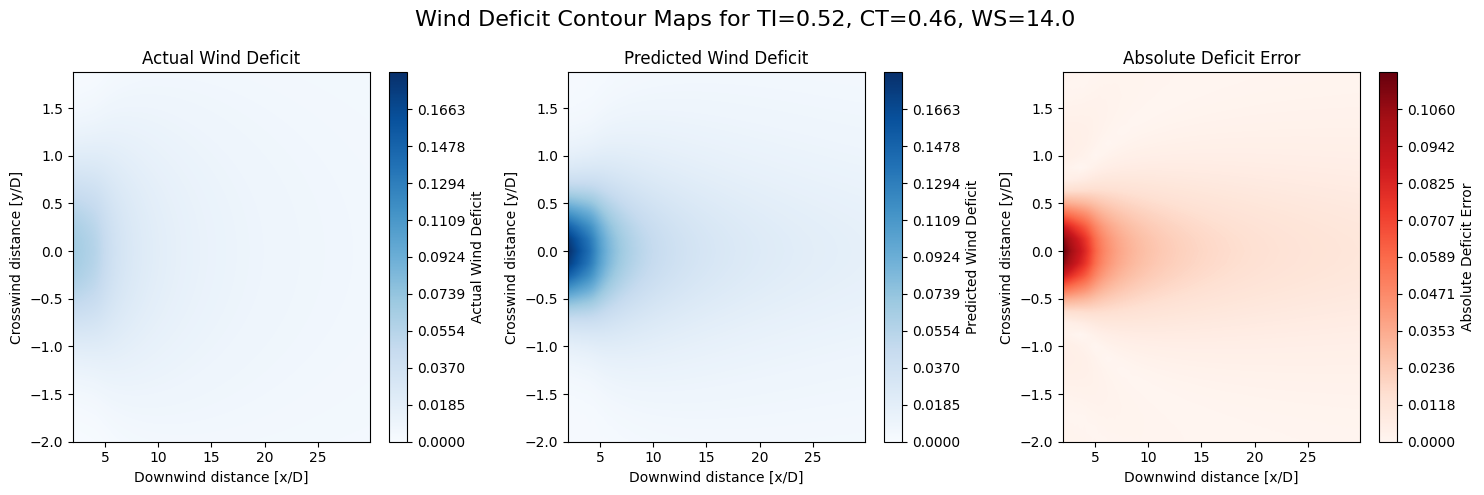

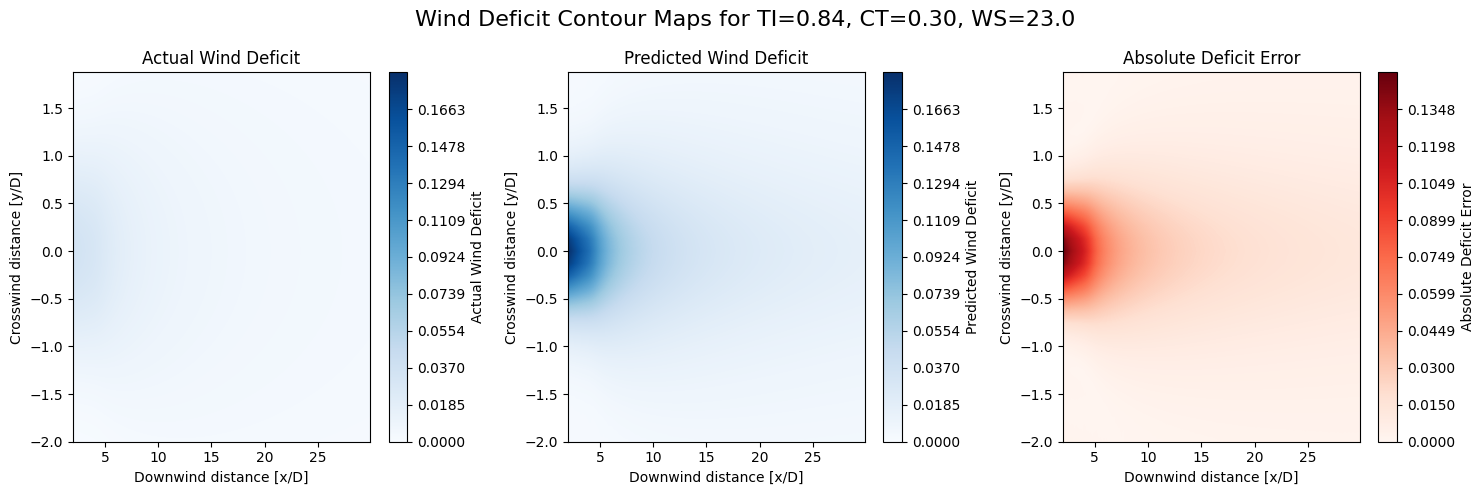

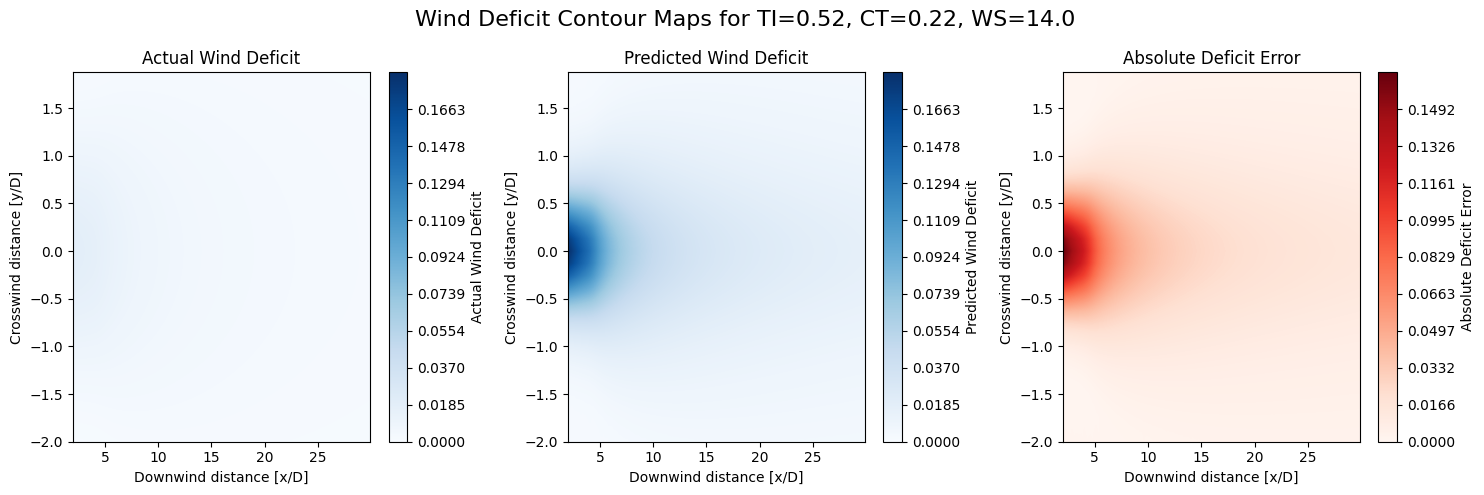

KeyboardInterrupt: 

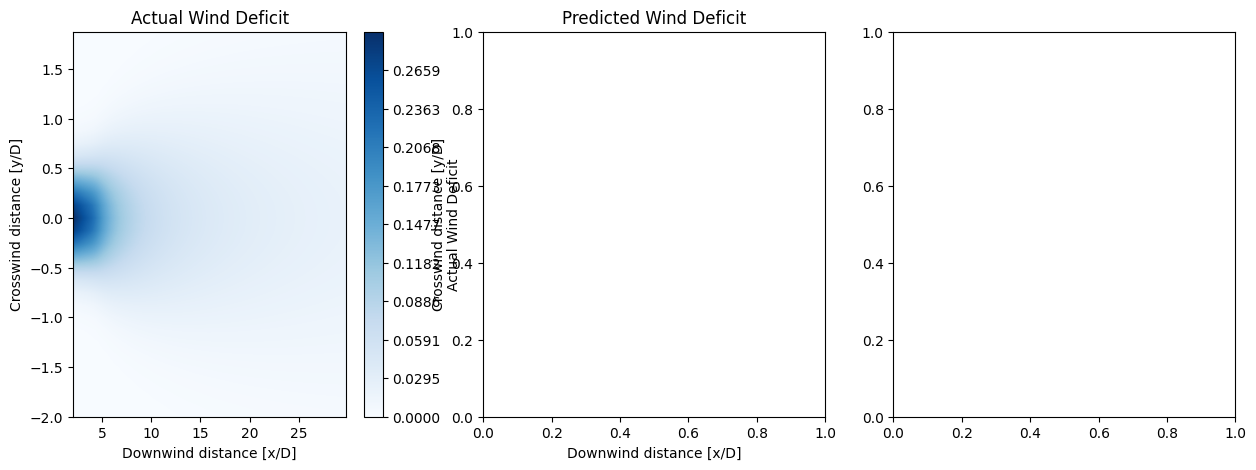

In [ ]:
test_dataset = test_dataloader.dataset
indices = list(range(len(test_dataset)))
random.shuffle(indices)
with torch.no_grad():
    for idx in indices:
        ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_multivariate(model, idx)
        
        plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')